# **Reinforcement Learning Applications for Solving Rubik's Cubes: From Q-Learning to Deep RL**

## **Introduction**
This notebook was developed by **Chaima Balti**, a student in the MINDS program, as part of the Deep Learning module under the supervision of **Ms. Radhia Bessi**. It focuses on the application of Reinforcement Learning (RL) and is divided into two main sections:

1. **Q-Learning for a 2x2 Rubik's Cube:** This section demonstrates the implementation of a simple Q-learning algorithm developed from scratch. Specific optimization techniques are applied to enhance the algorithm's performance and efficiency.

2. **Deep Reinforcement Learning for a 3x3 Rubik's Cube:** This section leverages the `jumunji` library, developed by InstaDeep, to solve a 3x3 Rubik's Cube using DeepRL methods.


<div style="text-align: center;">
    <img src="2x2cube.png" alt="2x2cube" style="width: 290px; margin: 10px;">
    <img src="3x3cube.png" alt="3x3cube" style="width: 400px; margin: 10px;">
</div>

## **Part I : Q-Learning for a 2x2 Rubik's Cube**

### <span style="color:rgb(4,139,154)"> Libraries

In [211]:
import numpy as np
import random

### <span style="color:rgb(4,139,154)"> Q-Learning Algorithm

Q-Learning is a model-free reinforcement learning (RL) algorithm that allows an agent to learn how to act optimally in a Markov Decision Process (MDP) environment. It is widely used for solving problems where an agent needs to make a sequence of decisions to maximize cumulative rewards. The core idea of Q-Learning is to estimate the **quality** of actions taken in certain states, stored in a **Q-table**, and iteratively improve these estimates as the agent interacts with the environment.

**Key Concepts**

- **State (S)**: Represents the current situation of the agent in the environment.
- **Action (A)**: The choices available to the agent to interact with the environment.
- **Reward (R)**: A scalar feedback signal received after performing an action in a state.
- **Q-value (Q)**: A value that represents the expected future reward for a given state-action pair, used to guide the agent's decision-making process.

**Q-Learning Process**

The algorithm works by updating a Q-table that stores the Q-values for state-action pairs. At each step, the agent chooses an action, observes the resulting reward, and updates the Q-value using the Q-learning update rule:

$$
Q(s_t, a_t) = Q(s_t, a_t) + /alpha \left( R_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t) \right)
$$

Where:
- $ Q(s_t, a_t) $ is the current Q-value for the state-action pair.
- $ \alpha $ is the learning rate, controlling how much new information overrides the old.
- $ R_{t+1} $ is the reward obtained after taking action $ a_t $ in state $ s_t $.
- $ \gamma $ is the discount factor, representing the importance of future rewards.
- $ \max_{a} Q(s_{t+1}, a) $ is the maximum Q-value of the next state over all possible actions.

**Q-Learning Steps**

1. **Initialize Q-table**: Start with an empty Q-table where each state-action pair has an initial Q-value (often set to 0).
2. **Choose Action**: Use an exploration strategy (like epsilon-greedy) to choose an action based on the current state.
3. **Update Q-values**: After taking the action, observe the reward and the next state. Update the Q-value for the state-action pair.
4. **Repeat**: Continue the process until the agent learns an optimal policy for selecting actions.

Q-learning is powerful because it doesn't require a model of the environment, and it can learn the optimal policy purely through interaction. It has been successfully applied to various problems, including games, robotics, and decision-making tasks.


### <span style="color:rgb(4,139,154)"> Definition of the environment Class RubiksCube2x2Env

The `RubiksCube2x2Env` class provides an environment for simulating and interacting with a 2x2 Rubik's Cube. This environment is designed to represent the cube's state, handle various actions (such as rotations), and assess whether the cube is solved. It includes key methods for resetting the cube to its solved state, scrambling it, and applying different rotations (U, D, L, R, F, B, and their counterclockwise counterparts). Additionally, the class implements a mechanism to choose actions using an epsilon-greedy policy, useful in reinforcement learning scenarios.

**Key Features**
- **State Representation**: The cube is represented as a list of six faces, each containing four stickers, which can be modified through rotations.
- **Actions**: A set of predefined actions (U, U', F, F', etc.) that can manipulate the cube's state.
- **Solving Logic**: Methods to check if the cube is solved by ensuring that all stickers on each face are the same color.
- **Q-Learning Integration**: A method to choose actions based on an epsilon-greedy policy, which can be used for reinforcement learning to solve the cube.


In [212]:
class RubiksCube2x2Env:
    def __init__(self):
        self.reset() # Initialize the solved cube (a list of six faces)
        self.max_face_number = 0 # Maximum Number of faces solved
        self.actions = ['U', "U'", 'F', "F'", 'R', "R'", 'L', "L'", 'D', "D'", 'B', "B'"] # Define the actions: U, F, R, L, D, B and their counterclockwise counterparts

    def reset(self):
        """
        Resets the environment to the solved state.
        The cube is represented as a list of 6 faces, each having 4 stickers.
        """
        self.cube = [['W']*4, ['R']*4, ['G']*4, ['B']*4, ['O']*4, ['Y']*4]  # Solved state
        self.state = self.get_state() 
        self.max_face_number = 0 
        return self.state 

    def scramble(self, num_moves=10):
        """
        Scrambles the cube by performing a random sequence of moves.
        """
        for _ in range(num_moves):
            action = random.choice(self.actions)
            self.apply_action(action)
        return self.get_state()

    def is_solved(self):
        """
        Check if the cube is solved. A solved cube has all stickers of each face the same color.
        """
        return all(len(set(face)) == 1 for face in self.cube)

    def get_state(self):
        """
        Converts the cube to a tuple of tuples (to be hashable) for use as a state representation.
        """
        return tuple(tuple(face) for face in self.cube)

    def apply_action(self, action):
        if action == "U":
            self._rotate_u()
        elif action == "U'":
            self._rotate_u_prime()
        elif action == "D":
            self._rotate_d()
        elif action == "D'":
            self._rotate_d_prime()
        elif action == "R":
            self._rotate_r()
        elif action == "R'":
            self._rotate_r_prime()
        elif action == "L":
            self._rotate_l()
        elif action == "L'":
            self._rotate_l_prime()
        elif action == "F":
            self._rotate_f()
        elif action == "F'":
            self._rotate_f_prime()
        elif action == "B":
            self._rotate_b()
        elif action == "B'":
            self._rotate_b_prime()

    # Function to apply an action to the cube (rotation)
    def _rotate_face_clockwise(self, face):
        """Rotate a 2x2 face 90 degrees clockwise."""
        return [face[2], face[0], face[3], face[1]]

    def _rotate_face_counterclockwise(self, face):
        """Rotate a 2x2 face 90 degrees counterclockwise."""
        return [face[1], face[3], face[0], face[2]]

    def _rotate_u(self):
        # U: F[0,1] <-> L[0,1] <-> B[0,1] <-> R[0,1]
        self.cube[2] = self._rotate_face_clockwise(self.cube[2])  
        self.cube[0][0:2], self.cube[4][0:2], self.cube[1][0:2], self.cube[5][0:2] = \
        self.cube[4][0:2], self.cube[1][0:2], self.cube[5][0:2], self.cube[0][0:2]

    def _rotate_u_prime(self):
        self.cube[2] = self._rotate_face_counterclockwise(self.cube[2])
        self.cube[0][0:2], self.cube[4][0:2], self.cube[1][0:2], self.cube[5][0:2] = \
        self.cube[5][0:2], self.cube[0][0:2], self.cube[4][0:2], self.cube[1][0:2]

    def _rotate_d(self):
        # D: F[2,3] <-> R[2,3] <-> B[2,3] <-> L[2,3]
        self.cube[3] = self._rotate_face_clockwise(self.cube[3])  # Bottom face
        self.cube[0][2:4], self.cube[5][2:4], self.cube[1][2:4], self.cube[4][2:4] = \
        self.cube[5][2:4], self.cube[1][2:4], self.cube[4][2:4], self.cube[0][2:4]

    def _rotate_d_prime(self):
        self.cube[3] = self._rotate_face_counterclockwise(self.cube[3])
        self.cube[0][2:4], self.cube[5][2:4], self.cube[1][2:4], self.cube[4][2:4] = \
        self.cube[4][2:4], self.cube[0][2:4], self.cube[5][2:4], self.cube[1][2:4]

    def _rotate_l(self):
        # L: F[0,2] <-> D[0,2] <-> B[1,3] <-> U[0,2]
        self.cube[4] = self._rotate_face_clockwise(self.cube[4])  # Left face
        temp = [self.cube[0][0], self.cube[0][2]]
        self.cube[0][0], self.cube[0][2] = self.cube[3][0], self.cube[3][2]
        self.cube[3][0], self.cube[3][2] = self.cube[1][3], self.cube[1][1]
        self.cube[1][3], self.cube[1][1] = self.cube[2][0], self.cube[2][2]
        self.cube[2][0], self.cube[2][2] = temp

    def _rotate_l_prime(self):
        self.cube[4] = self._rotate_face_counterclockwise(self.cube[4])
        temp = [self.cube[0][0], self.cube[0][2]]
        self.cube[0][0], self.cube[0][2] = self.cube[2][0], self.cube[2][2]
        self.cube[2][0], self.cube[2][2] = self.cube[1][3], self.cube[1][1]
        self.cube[1][3], self.cube[1][1] = self.cube[3][0], self.cube[3][2]
        self.cube[3][0], self.cube[3][2] = temp

    def _rotate_r(self):
        # R: F[1,3] <-> U[1,3] <-> B[0,2] <-> D[1,3]
        self.cube[5] = self._rotate_face_clockwise(self.cube[5])  # Right face
        temp = [self.cube[0][1], self.cube[0][3]]
        self.cube[0][1], self.cube[0][3] = self.cube[2][1], self.cube[2][3]
        self.cube[2][1], self.cube[2][3] = self.cube[1][2], self.cube[1][0]
        self.cube[1][2], self.cube[1][0] = self.cube[3][1], self.cube[3][3]
        self.cube[3][1], self.cube[3][3] = temp

    def _rotate_r_prime(self):
        self.cube[5] = self._rotate_face_counterclockwise(self.cube[5])
        temp = [self.cube[0][1], self.cube[0][3]]
        self.cube[0][1], self.cube[0][3] = self.cube[3][1], self.cube[3][3]
        self.cube[3][1], self.cube[3][3] = self.cube[1][2], self.cube[1][0]
        self.cube[1][2], self.cube[1][0] = self.cube[2][1], self.cube[2][3]
        self.cube[2][1], self.cube[2][3] = temp

    def _rotate_f(self):
        # F: U[2,3] <-> L[1,3] <-> D[0,1] <-> R[0,2]
        self.cube[0] = self._rotate_face_clockwise(self.cube[0])  # Front face
        temp = [self.cube[2][2], self.cube[2][3]]
        self.cube[2][2], self.cube[2][3] = self.cube[4][3], self.cube[4][1]
        self.cube[4][3], self.cube[4][1] = self.cube[3][0], self.cube[3][1]
        self.cube[3][0], self.cube[3][1] = self.cube[5][0], self.cube[5][2]
        self.cube[5][0], self.cube[5][2] = temp

    def _rotate_f_prime(self):
        self.cube[0] = self._rotate_face_counterclockwise(self.cube[0])
        temp = [self.cube[2][2], self.cube[2][3]]
        self.cube[2][2], self.cube[2][3] = self.cube[5][0], self.cube[5][2]
        self.cube[5][0], self.cube[5][2] = self.cube[3][0], self.cube[3][1]
        self.cube[3][0], self.cube[3][1] = self.cube[4][3], self.cube[4][1]
        self.cube[4][3], self.cube[4][1] = temp

    def _rotate_b(self):
        # B: U[0,1] <-> R[1,3] <-> D[2,3] <-> L[0,2]
        self.cube[1] = self._rotate_face_clockwise(self.cube[1])  # Back face
        temp = [self.cube[2][0], self.cube[2][1]]
        self.cube[2][0], self.cube[2][1] = self.cube[5][1], self.cube[5][3]
        self.cube[5][1], self.cube[5][3] = self.cube[3][2], self.cube[3][3]
        self.cube[3][2], self.cube[3][3] = self.cube[4][0], self.cube[4][2]
        self.cube[4][0], self.cube[4][2] = temp

    def _rotate_b_prime(self):
        self.cube[1] = self._rotate_face_counterclockwise(self.cube[1])
        temp = [self.cube[2][0], self.cube[2][1]]
        self.cube[2][0], self.cube[2][1] = self.cube[4][0], self.cube[4][2]
        self.cube[4][0], self.cube[4][2] = self.cube[3][2], self.cube[3][3]
        self.cube[3][2], self.cube[3][3] = self.cube[5][1], self.cube[5][3]
        self.cube[5][1], self.cube[5][3] = temp

    def choose_action(self, q_table, epsilon=0.1):
        """
        Chooses an action based on epsilon-greedy policy.
        """
        if random.uniform(0, 1) < epsilon:
            # Exploration: choose a random action
            return random.choice(self.actions)
        else:
            # Exploitation: choose the action with the highest Q-value
            if self.state not in q_table:
                q_table[self.state] = {action: 0 for action in self.actions}
            return max(q_table[self.state], key=q_table[self.state].get)

    def count_solved_faces(self):
        """
        Counts the number of fully solved faces.
        A fully solved face has all stickers of the same color.
        """
        return sum(face.count(face[0]) == len(face) for face in self.cube)
    

    def step(self, action, q_table, alpha=0.1, gamma=0.9):
        """
        Takes an action, applies it to the cube, and returns the new state, reward, and whether the episode is done.
        """
        # Apply the action to get the next state
        self.apply_action(action)
        next_state = self.get_state()

         # Calculate reward based on the number of solved faces
        solved_faces = self.count_solved_faces()
        
        if self.is_solved():
            reward = 60  # Highest reward for solving the entire cube
        elif solved_faces < 3 and solved_faces > self.max_face_number: # This condition is made so that the agent won't keep getting rewards for making no progress 
            reward = 0.2*solved_faces  # Reward for the number of solved faces (0 to 5)
        else :
            reward = 0
        self.max_face_number = max ( self.max_face_number , solved_faces )
        
        # Add a small penalty for each move to encourage faster solutions
        reward -= 0.1

        # Update the Q-value using the Q-learning update rule
        if next_state not in q_table:
            q_table[next_state] = {action: 0 for action in self.actions}

        best_next_action = max(q_table[next_state], key=q_table[next_state].get)
        q_table[self.state][action] += alpha * (reward + gamma * q_table[next_state][best_next_action] - q_table[self.state][action])

        # Move to the next state
        self.state = next_state

        # Return the next state, reward, and whether the cube is solved
        return next_state, reward, self.is_solved()

### <span style="color:rgb(4,139,154)"> Optimizations And Improvements Points

1. **Normalization of State for Efficient Q-table Representation**  
   In the `shift_colors` function, a key optimization is introduced by standardizing the cube's state representation. The goal of this function is to reduce the size of the Q-table by introducing equivalence between cube states. By making the solved face always the top face (or white face), we eliminate redundant states. This ensures that multiple equivalent cube configurations (which are rotations of the solved state) are treated as the same state by the model.

2. **Reward Calculation to Encourage Progress**  
   In the `step` function, an important optimization is implemented to avoid giving rewards for states with no progress. The key points of optimization are:
   - **Reward Based on Solved Faces**: The reward is based on the number of solved faces, with a higher reward for solving the entire cube. This ensures that the agent is motivated to solve the puzzle step by step.
   - **Penalty for Stagnation**: A condition checks if the number of solved faces has not improved since the last step. If there is no progress, the agent receives a reward of zero. This helps the agent avoid getting stuck in suboptimal states and encourages it to keep making progress.
   - **Small Move Penalty**: A small penalty is applied for each move to encourage the agent to find the optimal solution faster. This optimizes the learning process by discouraging unnecessary moves and encouraging efficiency.

In [213]:
def find_solved_face(cube):
    """ Find a solved face, if it exists. Returns the color of the solved face. """
    for i, face in enumerate(cube):
        if len(set(face)) == 1:
            return i, face[0]  # Return the index and color of the solved face
    return None, None

def shift_colors(cube, shift_index):
    """
    Shift the colors in a Rubik's Cube representation based on a given index.
    
    Parameters:
    - cube (list of lists): A 2x2 Rubik's Cube represented as a list of 6 lists, each with 4 elements.
    - shift_index (int): The index by which to shift the color mapping.
    
    Returns:
    - Modified cube with colors shifted.
    """
    
    # Original color to number mapping
    color_map = {
        'W': 0,  # White
        'R': 1,  # Red
        'G': 2,  # Green
        'Y': 3,  # Yellow
        'O': 4,  # Orange
        'B': 5   # Blue
    }
    
    # Reverse mapping for easy number to color conversion
    num_to_color = {v: k for k, v in color_map.items()}
    
    # Shift the color map by the given index
    colors = ['W', 'R', 'G', 'Y', 'O', 'B']
    shifted_colors = colors[shift_index:] + colors[:shift_index]
    
    # Create the new color mapping based on the shift
    shifted_color_map = {color_map[color]: num_to_color[i] for i, color in enumerate(shifted_colors)}
    
    # Replace the colors in the cube with the shifted colors
    new_cube = []
    for face in cube:
        new_face = [shifted_color_map[color_map[color]] for color in face]
        new_cube.append(new_face)
    
    return new_cube

def modify_cube(cube):
    """
    Normalize the cube state so that a solved face becomes the white face.
    This involves rotating the cube to make the solved face the top face
    and translating colors accordingly.

        * The goal of this function is to optimize the size of the q_table (table of states)
          by introducing the concept of equivalence to the model's agent and this translates
          as making the first solved face the "white" or the "top" one. 
    
    This function modifies the cube as follows:
    1. Swaps the 3rd and 5th faces of the cube.
    2. Rotates the list of faces so that the solved face (given by index_solved) becomes the first face.
    3. Swaps the 3rd and 5th faces back to their original positions.
    4. Returns the modified cube.
    
    Parameters:
    - cube (list of list): A 2x2 Rubik's cube represented as a list of 6 lists, each containing 4 elements.
    - index_solved (int): The index of the solved face (0 to 5).
    
    Returns:
    - Modified cube (list of list). 
    """
    # Step 1: Swap the 3rd (index 2) and 5th (index 4) faces
    cube[3], cube[5] = cube[5], cube[3]
    index_solved, color_solved = find_solved_face(cube)
    # Step 2: Rotate (slide) the cube so that index_solved becomes the first face
    # This is equivalent to rotating the list to have index_solved at index 0
    if index_solved :
        cube = cube[index_solved:] + cube[:index_solved]
        cube = shift_colors(cube, index_solved)
    # Step 3: Swap the 3rd (index 2) and 5th (index 4) faces back to their original positions
    cube[3], cube[5] = cube[5], cube[3]
  
    # Return the modified cube
    return cube

### <span style="color:rgb(4,139,154)"> Training the model

In [214]:
# Training Loop
def train_agent(num_episodes, q_table):
    env = RubiksCube2x2Env()
    epsilon = 0.5  # Exploration rate
    alpha = 0.2    # Learning rate
    gamma = 0.9    # Discount factor
    episode_history = []  # Track states and actions for the current episode
    found_one = 0
    for episode in range(num_episodes):
        # Reset the environment at the start of each episode
        env.reset()
        env.scramble(20)
        i = env.get_state()
        step = 0
        # Reduce exploration rate over time
        if epsilon > 0.01:
            epsilon *= 0.9
        while not env.is_solved() and step < 15: 
            step +=1
            # Choose an action
            action = env.choose_action(q_table, epsilon)
            # Add current state, action, and reward to the episode history
            #env.cube = modify_cube(env.cube)
            # Take the action and get the next state, reward, and done flag
            next_state, reward, done = env.step(action, q_table, alpha, gamma)
            if not found_one :
                episode_history.append({
                    'state': next_state,
                    'action': action,
                })
                # If the cube is not solved, discard the episode history
                if not env.is_solved() and step == 15 :
                    episode_history = []
                elif env.is_solved() :
                    init = i
                    found_one = 1
            if step == 1 : cum_reward = reward
            cum_reward += reward
            if done:
                print("*************************************************Solved!********************************************************")
                print( "Episode n°", episode, "reward = ", cum_reward, "in ", step , "steps, SOLVED :D !!!!!!")
                break
            
        if episode % 10**5 == 0:
          print( "Episode n°", episode, "reward = ", cum_reward, "in ", step , "steps")

    return q_table , init, episode_history

In [215]:
# Training the agent
q_table = {}
q_table, init , Exemple_solved_cube = train_agent(10**5, q_table)

Episode n° 0 reward =  -1.6000000000000003 in  15 steps
*************************************************Solved!********************************************************
Episode n° 3120 reward =  59.699999999999996 in  10 steps, SOLVED :D !!!!!!
*************************************************Solved!********************************************************
Episode n° 18619 reward =  60.5 in  2 steps, SOLVED :D !!!!!!
*************************************************Solved!********************************************************
Episode n° 30007 reward =  59.699999999999996 in  10 steps, SOLVED :D !!!!!!
*************************************************Solved!********************************************************
Episode n° 86086 reward =  59.3 in  10 steps, SOLVED :D !!!!!!


### Animation

In [216]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

%matplotlib inline

In [217]:
Exemple_solved_cube = [{'state': (('W', 'W', 'R', 'R'),
   ('R', 'R', 'W', 'W'),
   ('O', 'O', 'G', 'G'),
   ('Y', 'Y', 'B', 'B'),
   ('B', 'O', 'Y', 'G'),
   ('Y', 'G', 'B', 'O')),
  'action': 'U'},
 {'state': (('B', 'O', 'R', 'R'),
   ('Y', 'G', 'W', 'W'),
   ('G', 'O', 'G', 'O'),
   ('Y', 'Y', 'B', 'B'),
   ('R', 'R', 'Y', 'G'),
   ('W', 'W', 'B', 'O')),
  'action': 'U'},
 {'state': (('R', 'R', 'R', 'R'),
   ('W', 'W', 'W', 'W'),
   ('G', 'G', 'O', 'O'),
   ('Y', 'Y', 'B', 'B'),
   ('Y', 'G', 'Y', 'G'),
   ('B', 'O', 'B', 'O')),
  'action': 'U'},
 {'state': (('Y', 'G', 'R', 'R'),
   ('B', 'O', 'W', 'W'),
   ('O', 'G', 'O', 'G'),
   ('Y', 'Y', 'B', 'B'),
   ('W', 'W', 'Y', 'G'),
   ('R', 'R', 'B', 'O')),
  'action': 'U'},
 {'state': (('W', 'W', 'R', 'R'),
   ('R', 'R', 'W', 'W'),
   ('O', 'O', 'G', 'G'),
   ('Y', 'Y', 'B', 'B'),
   ('B', 'O', 'Y', 'G'),
   ('Y', 'G', 'B', 'O')),
  'action': 'U'},
 {'state': (('Y', 'G', 'R', 'R'),
   ('B', 'O', 'W', 'W'),
   ('O', 'G', 'O', 'G'),
   ('Y', 'Y', 'B', 'B'),
   ('W', 'W', 'Y', 'G'),
   ('R', 'R', 'B', 'O')),
  'action': "U'"},
 {'state': (('R', 'R', 'R', 'R'),
   ('W', 'W', 'W', 'W'),
   ('G', 'G', 'O', 'O'),
   ('Y', 'Y', 'B', 'B'),
   ('Y', 'G', 'Y', 'G'),
   ('B', 'O', 'B', 'O')),
  'action': "U'"},
 {'state': (('B', 'O', 'R', 'R'),
   ('Y', 'G', 'W', 'W'),
   ('G', 'O', 'G', 'O'),
   ('Y', 'Y', 'B', 'B'),
   ('R', 'R', 'Y', 'G'),
   ('W', 'W', 'B', 'O')),
  'action': "U'"},
 {'state': (('R', 'R', 'R', 'R'),
   ('W', 'W', 'W', 'W'),
   ('G', 'G', 'O', 'O'),
   ('Y', 'Y', 'B', 'B'),
   ('Y', 'G', 'Y', 'G'),
   ('B', 'O', 'B', 'O')),
  'action': 'U'},
 {'state': (('R', 'R', 'R', 'R'),
   ('W', 'W', 'W', 'W'),
   ('G', 'G', 'G', 'G'),
   ('B', 'B', 'B', 'B'),
   ('Y', 'Y', 'Y', 'Y'),
   ('O', 'O', 'O', 'O')),
  'action': 'F'}]

In [218]:

def plot_cube_state(state, face_positions):
    # Define the color map for the Rubik's Cube
    color_map = {'W': 'white', 'R': 'red', 'B': 'blue', 
                 'G': 'green', 'Y': 'yellow', 'O': 'orange'}
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1, 7)
    ax.set_ylim(-1, 7)
    ax.set_aspect('equal')
    ax.axis('off')
    # Iterate over each face of the cube and plot it
    for face_index, face in enumerate(state):
        x_offset, y_offset = face_positions[face_index]
        for i, cell in enumerate(face):
            row = i // 2  # 2x2 layout: compute row index
            col = i % 2   # Compute column index
            color = color_map[cell]
            ax.add_patch(Rectangle(
                (x_offset + col, y_offset - row), 1, 1,
                facecolor=color, edgecolor='black'
            ))
    plt.show()

def animate_episode(episode):
    # Define face positions on the 2D grid
    face_positions = {
        0: (2, 4),  # Top face
        1: (2, 2),  # Front face
        2: (4, 2),  # Right face
        3: (0, 2),  # Left face
        4: (2, 0),  # Bottom face
        5: (2, 6),  # Back face
    }

    for frame in episode: 
        # Plot the current cube state
        clear_output(wait=True)
        plot_cube_state(frame['state'], face_positions)
        # Display the action performed
        time.sleep(0.2)

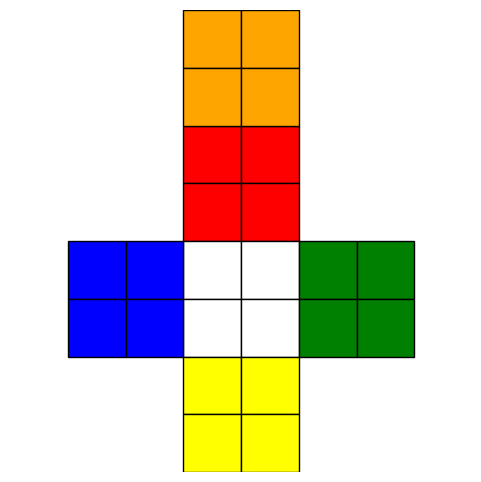

In [219]:
episode = Exemple_solved_cube  # You need to define 'Exemple_solved_cube'
animate_episode(episode)

*************************************************

## **Part II : DeepRL for a 3x3 Rubik's Cube**

### Libraries

In [220]:
# !pip install --quiet -U "jumanji[train] @ git+https://github.com/instadeepai/jumanji.git@main"

In [221]:
import pickle
from IPython.display import HTML

import jax
from huggingface_hub import hf_hub_download
from hydra import compose, initialize

from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device

import subprocess
import os
import requests


%matplotlib notebook

In [222]:
# @title Set up JAX for available hardware (run me) { display-mode: "form" }
# Based on https://stackoverflow.com/questions/67504079/how-to-check-if-an-nvidia-gpu-is-available-on-my-system
try:
    subprocess.check_output("nvidia-smi")
    print("a GPU is connected.")
except Exception:
    # TPU or CPU
    if "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
        import jax.tools.colab_tpu

        jax.tools.colab_tpu.setup_tpu()
        print("A TPU is connected.")
    else:
        print("Only CPU accelerator is connected.")

a GPU is connected.


### Setting The Environment

In [223]:
env = "rubiks_cube"  # @param ['bin_pack', 'cleaner', 'connector', 'cvrp', 'game_2048', 'graph_coloring', 'job_shop', 'knapsack', 'maze', 'minesweeper', 'mmst', 'multi_cvrp', 'robot_warehouse', 'rubiks_cube', 'snake', 'sudoku', 'tetris', 'tsp']
agent = "a2c"  # @param ['random', 'a2c']

In [224]:
# @title Download Jumanji Configs (run me) { display-mode: "form" }
def download_file(url: str, file_path: str) -> None:
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
    else:
        print("Failed to download the file.")


os.makedirs("configs", exist_ok=True)
config_url = "https://raw.githubusercontent.com/instadeepai/jumanji/main/jumanji/training/configs/config.yaml"
download_file(config_url, "configs/config.yaml")
env_url = f"https://raw.githubusercontent.com/instadeepai/jumanji/main/jumanji/training/configs/env/{env}.yaml"
os.makedirs("configs/env", exist_ok=True)
download_file(env_url, f"configs/env/{env}.yaml")

In [225]:
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config.yaml", overrides=[f"env={env}", f"agent={agent}"])
cfg

{'agent': 'a2c', 'seed': 0, 'logger': {'type': 'terminal', 'save_checkpoint': False, 'name': '${agent}_${env.name}'}, 'env': {'name': 'rubiks_cube', 'registered_version': 'RubiksCube-partly-scrambled-v0', 'network': {'cube_embed_dim': 4, 'step_count_embed_dim': 4, 'dense_layer_dims': [256, 256]}, 'training': {'num_epochs': 1000, 'num_learner_steps_per_epoch': 100, 'n_steps': 10, 'total_batch_size': 256}, 'evaluation': {'eval_total_batch_size': 1024, 'greedy_eval_total_batch_size': 1024}, 'a2c': {'normalize_advantage': False, 'discount_factor': 0.99, 'bootstrapping_factor': 0.95, 'l_pg': 1.0, 'l_td': 1.0, 'l_en': 0.01, 'learning_rate': 0.0003}}}

In [226]:
# Chose the corresponding checkpoint from the InstaDeep Model Hub
# https://huggingface.co/InstaDeepAI
REPO_ID = f"InstaDeepAI/jumanji-benchmark-a2c-{cfg.env.registered_version}"
FILENAME = f"{cfg.env.registered_version}_training_state"

model_checkpoint = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

with open(model_checkpoint, "rb") as f:
    training_state = pickle.load(f)

C:\Users\balti_j80n85d\AppData\Local\Temp\ipykernel_8216\2370677155.py:9: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  training_state = pickle.load(f)


In [227]:
params = first_from_device(training_state.params_state.params)
env = setup_env(cfg).unwrapped
agent = setup_agent(cfg, env)
policy = jax.jit(agent.make_policy(params.actor, stochastic=False))
if agent == "a2c":
    policy = lambda *args: policy(*args)[0]

### Exemple Of Episodes

In [228]:
NUM_EPISODES = 2

reset_fn = jax.jit(env.reset)
step_fn = jax.jit(env.step)
states = []
key = jax.random.PRNGKey(cfg.seed)
for episode in range(NUM_EPISODES):
    key, reset_key = jax.random.split(key)
    state, timestep = reset_fn(reset_key)
    states.append(state)
    while not timestep.last():
        key, action_key = jax.random.split(key)
        observation = jax.tree_util.tree_map(lambda x: x[None], timestep.observation)
        action, _ = policy(observation, action_key)
        state, timestep = step_fn(state, action.squeeze(axis=0))
        states.append(state)
    # Freeze the terminal frame to pause the GIF.
    for _ in range(3):
        states.append(state)

### Animation

In [229]:
HTML(env.animate(states, interval=150).to_jshtml())  

<IPython.core.display.Javascript object>